# Inspecting pulsar frequency data

We can produce data using the methods in `scripts/generate_frequency_timeseries.py`

Lets take a quick look at this data and check everything is reasonable.

We will use the "canonical" data, which has white, red and GWB noise.


---



First, load and plot the timeseries

In [31]:
import numpy as np 
data = np.load('../output_data/sandbox_14/frequency_timeseries.npz')
data.files

['f_tim_file', 'f_par_file', 'f_tim_file_clean']

There are three files, two 'tim file's which holds the frequency timeseries and a 'par file' which holds some parameters.

Lets plot the frequency timeseries of a single pulsar 

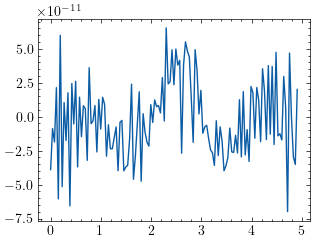

In [32]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')



y = data['f_tim_file']
t = y[:,-1]
tplot = t / (365*24*3600)
f = y[:,0]
plt.plot(tplot,f)


This looks reasonable. Remember that we have subtracted off the secular spindown trend.

To add back on the trend, we need the par file:

In [33]:
parameter_file = data['f_par_file']
f0  = parameter_file[0,:]
f1  = parameter_file[1,:]
DEC = parameter_file[2,:]
RA  = parameter_file[3,:]

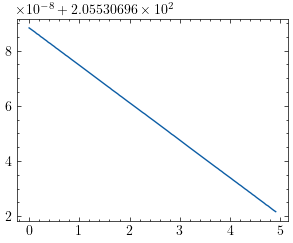

In [34]:
psr_idx = 0
f_secular = f0[psr_idx] + f1[psr_idx]*t + y[:,psr_idx]
plt.plot(tplot,f_secular)

## Sky position

Lets also check the RA and DEC look like what we might expect 

In [35]:
import matplotlib.pyplot as plt
import scienceplots
from mw_plot import mw_radec
plt.style.use('science')


def convert_ra(x,org):


    xnew = np.remainder(x+360-org,360) # shift RA values
    ind = xnew>180
    xnew[ind] -=360    # scale conversion to [-180, 180]
    xnew=-xnew    # reverse the scale: East to the left

    return xnew

def degrees_to_hours(x):


    return x/15.0

def plot_mwd(RA,Dec,d,org=0, projection='mollweide',cmap='viridis',savefig=None):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    modified from https://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html
    '''
    
    
    x = convert_ra(RA,org)

    #Setup the figure
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection)

    fs = 20
    
    
    #Plot the pulsars
    sc = ax.scatter(np.radians(x),np.radians(Dec),c=d,cmap=cmap)  # convert degrees to radians


    #Colorbar of distance
    cbar = plt.colorbar(sc,orientation='horizontal',fraction=0.06, pad=0.075,cmap=cmap)
    cbar.ax.set_xlabel('d [kpc]', rotation=0,fontsize=fs)



    mw_plane_ra, mw_plane_dec = mw_radec(deg=True)  # RA/DEC arrays of milkyway plane in degs
    mw_plane_ra = convert_ra(mw_plane_ra,org)
    ax.plot(np.radians(mw_plane_ra),np.radians(mw_plane_dec),c='0.5', linestyle='--')  # convert degrees to radians


    #Formatting
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    tick_labels = degrees_to_hours(tick_labels)

    string_tick_labels = [str(int(i))+'h' for i in tick_labels]
    ax.set_xticklabels(string_tick_labels)     # we add the scale on the x axis


    #ax.set_xlabel("Right Ascension",fontsize=fs)
    #ax.set_ylabel("Declination", fontsize=fs)
    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)
    cbar.ax.xaxis.set_tick_params(labelsize=fs-4)
    cbar.ax.xaxis.set_major_locator(plt.MaxNLocator(7))


    
    ax.grid(True)



    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)


    plt.show()


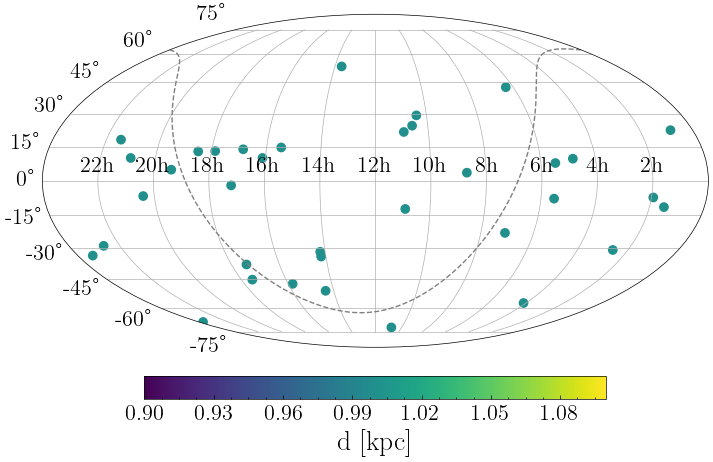

In [36]:
d = np.ones(len(RA))
RA_deg = RA*180.0/np.pi
DEC_deg = DEC*180.0/np.pi

plot_mwd(RA_deg*180,DEC_deg,d,org=180, projection='mollweide',savefig=None)

### Plot multiple timeseries

Before we looked just at the data from a single pulsar.

Lets look at a few more all at once

In [40]:
import numpy as np 
import matplotlib.pyplot as plt 

def process_data_file(y,num_to_plot):

    t = y[:,-1]
    tplot = t / (365*24*3600)
    plt.figsize=(12,12)
    for i in range(num_to_plot):
        plt.plot(tplot,y[:,i])

    plt.show()


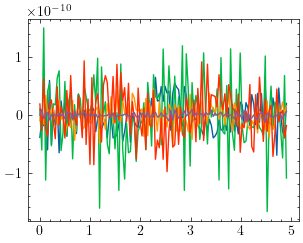

In [41]:
num_to_plot = 5
process_data_file(y,num_to_plot)

# Inpsect the zero measurement noise timeseries

This is (sort of?) the object that we want the Kalman filter to recover 

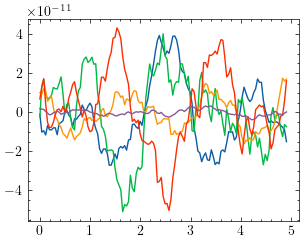

In [43]:
y_clean = data['f_tim_file_clean']
process_data_file(y_clean,num_to_plot)

Lets plot the actual measurement and the clean measurement overlaid:

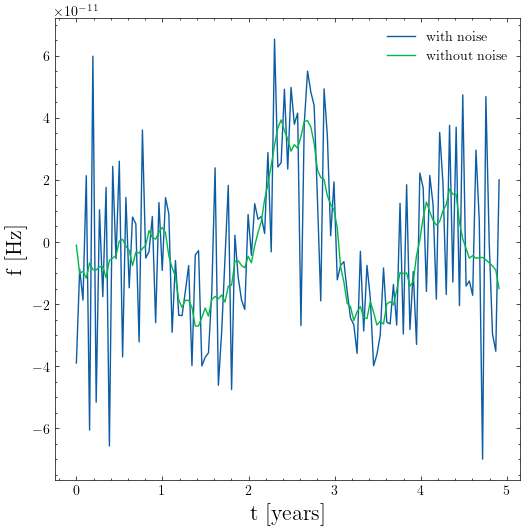

In [53]:
psr_index = 0

t = y[:,-1]
tplot = t / (365*24*3600)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)



ax.plot(tplot,y[:,psr_index],label='with noise')
ax.plot(tplot,y_clean[:,psr_index], label = 'without noise')


fs = 16 
ax.set_xlabel('t [years]',fontsize=fs)
ax.set_ylabel('f [Hz]',fontsize=fs)
ax.legend()